#VGG19

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import LeakyReLU


data_dir = '/content/drive/MyDrive/Colab Notebooks/Tesis/aves_galapagos'

classes = os.listdir(data_dir)

def verify_directories(data_dir, classes):
    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            raise FileNotFoundError(f"Directorio no encontrado: {class_dir}")

verify_directories(data_dir, classes)

all_images = []
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    images = os.listdir(class_dir)
    for image in images:
        all_images.append((os.path.join(class_dir, image), class_name))
random.shuffle(all_images)

x_data, y_data = zip(*all_images)

image_size = (224, 224)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.111, random_state=42)

data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

def create_data_generator(dataframe, target_size, batch_size, shuffle=True, seed=42):
    return data_generator.flow_from_dataframe(
        dataframe=dataframe,
        x_col='image_path',
        y_col='class_name',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=shuffle,
        seed=seed,
        classes=classes
    )

train_df = pd.DataFrame({'image_path': x_train, 'class_name': y_train})
val_df = pd.DataFrame({'image_path': x_val, 'class_name': y_val})
test_df = pd.DataFrame({'image_path': x_test, 'class_name': y_test})

train_data = create_data_generator(train_df, image_size, batch_size=32)
val_data = create_data_generator(val_df, image_size, batch_size=32)
test_data = create_data_generator(test_df, image_size, batch_size=32, shuffle=False)

vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg_model.layers[:-4]:
    layer.trainable = False

model = Sequential()

model.add(vgg_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation=LeakyReLU(alpha=0.3)))
model.add(Dropout(0.3))
model.add(Dense(256, activation=LeakyReLU(alpha=0.3)))
model.add(Dropout(0.3))


model.add(Dense(len(classes), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

start_time = time.time()

history = model.fit(train_data, epochs=30, validation_data=val_data, callbacks=[early_stopping])

execution_time = time.time() - start_time

test_loss, test_accuracy = model.evaluate(test_data)

y_pred_prob = model.predict(test_data)
y_pred = np.argmax(y_pred_prob, axis=1)

y_true = test_data.classes

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

print(f"Time in: {execution_time:.2f} seconds")

Found 5830 validated image filenames belonging to 58 classes.
Found 728 validated image filenames belonging to 58 classes.
Found 729 validated image filenames belonging to 58 classes.
80134624/80134624 [==============================] - 0s 0us/step
Epoch 1/30
183/183 [==============================] - 1911s 10s/step - loss: 3.8460 - accuracy: 0.1202 - val_loss: 3.6873 - val_accuracy: 0.1387
Epoch 2/30
183/183 [==============================] - 120s 657ms/step - loss: 3.4383 - accuracy: 0.1628 - val_loss: 2.9092 - val_accuracy: 0.2473
Epoch 3/30
183/183 [==============================] - 120s 656ms/step - loss: 2.6678 - accuracy: 0.2775 - val_loss: 2.3026 - val_accuracy: 0.3599
Epoch 4/30
183/183 [==============================] - 128s 702ms/step - loss: 2.2541 - accuracy: 0.3593 - val_loss: 1.9649 - val_accuracy: 0.4492
Epoch 5/30
183/183 [==============================] - 123s 671ms/step - loss: 1.9457 - accuracy: 0.4432 - val_loss: 1.7212 - val_accuracy: 0.4890
Epoch 6/30
183/183 [==

In [ ]:
model.save('MYVGG19.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!ls

drive  MYVGG19.h5  sample_data


In [ ]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.6 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.15.0
    Uninstalling wrapt-1.15.0:
      Successfully uninstalled wrapt-1.15.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.13.0
    Uninstalling tensorflow-estimator-2.13.0:
      Successfully uninstalled tensorflow-estimator-2

In [ ]:
!mkdir output_folder

In [ ]:
!tensorflowjs_converter --input_format keras MYVGG19.h5 output_folder

2023-10-22 01:22:12.196597: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-22 01:22:12.196680: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-22 01:22:12.196728: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-22 01:22:14.232419: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
!ls output_folder

group1-shard10of20.bin	group1-shard16of20.bin	group1-shard2of20.bin  group1-shard8of20.bin
group1-shard11of20.bin	group1-shard17of20.bin	group1-shard3of20.bin  group1-shard9of20.bin
group1-shard12of20.bin	group1-shard18of20.bin	group1-shard4of20.bin  model.json
group1-shard13of20.bin	group1-shard19of20.bin	group1-shard5of20.bin
group1-shard14of20.bin	group1-shard1of20.bin	group1-shard6of20.bin
group1-shard15of20.bin	group1-shard20of20.bin	group1-shard7of20.bin


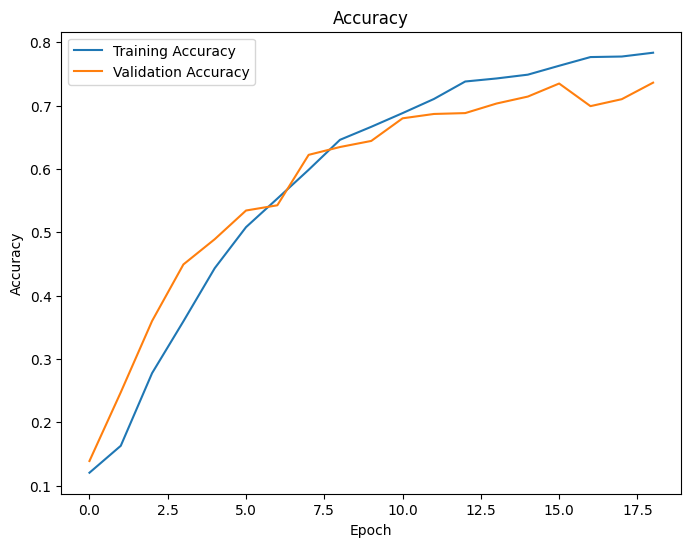

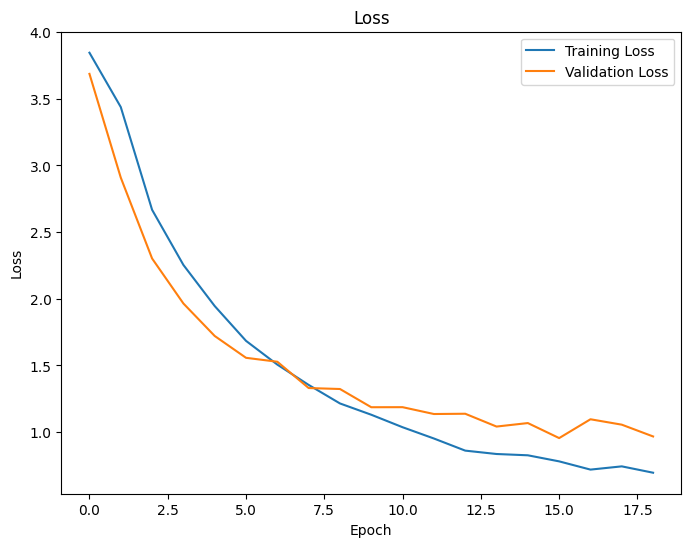

In [ ]:
import matplotlib.pyplot as plt

train_accuracy = history.history['accuracy']
train_loss = history.history['loss']

val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 6))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
